In [ ]:
# Task 7: Sales Forecasting Description 

# Dataset (Recommended): Walmart Sales Forecast (Kaggle)
# Predict future sales based on historical sales data
# Create time-based features (day, month, lag values)
# Apply regression models to forecast next period's sales
# Plot actual vs. predicted values over time

# Tools: pandas, numpy, matplotlib, scikit-learn, statsmodels
# Libraries: pandas, numpy, matplotlib, seaborn, scikit-learn, statsmodels, kagglehub
# Covered: Data Loading, EDA, Feature Engineering, Model Training, Evaluation, Visualization
# Estimated Time: 7-8 hours
# Dataset Link: https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast

In [7]:
#Import System Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

import kagglehub

# Download latest version
path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")

print("Path to dataset files:", path)

100%|██████████| 3.36M/3.36M [00:00<00:00, 6.85MB/s]

Extracting files...
Path to dataset files: C:\Users\knguy\.cache\kagglehub\datasets\aslanahmedov\walmart-sales-forecast\versions\1


In [ ]:
#Import System Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

import kagglehub

# Download latest version
path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")

print("Path to dataset files:", path)

In [ ]:
# Aggregate to weekly sales if needed (optional)

df['WeekStart'] = df['Date'].dt.to_period('W').apply(lambda p: p.start_time)
agg = df.groupby('WeekStart', as_index=False)['Sales'].sum().rename(columns={'WeekStart':'Date'}).sort_values('Date')
ts = agg.reset_index(drop=True)

In [ ]:
# Creating Time-based Features

def create_features(df, lags=[1,2,3,4,12,26], rolling_windows=[4,12]):
    df = df.copy().sort_values('Date').reset_index(drop=True)
    # time-based features
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['weekofyear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    # cyclical encodings
    df['sin_week'] = np.sin(2*np.pi*df['weekofyear']/52)
    df['cos_week'] = np.cos(2*np.pi*df['weekofyear']/52)
    df['sin_month'] = np.sin(2*np.pi*df['month']/12)
    df['cos_month'] = np.cos(2*np.pi*df['month']/12)
    # lags
    for lag in lags:
        df[f'lag_{lag}'] = df['Sales'].shift(lag)
    # rolling
    for w in rolling_windows:
        df[f'roll_mean_{w}'] = df['Sales'].shift(1).rolling(window=w, min_periods=1).mean()
    # target is next week's sales
    df['target'] = df['Sales'].shift(-1)
    df = df.dropna().reset_index(drop=True)
    return df

features_df = create_features(ts)

In [16]:
# Time Series Train-Test Split for Regression

TEST_WEEKS = 12
train_df = features_df[:-TEST_WEEKS].copy()
test_df  = features_df[-TEST_WEEKS:].copy()

X_cols = [c for c in features_df.columns if c not in ['Date','Sales','target']]
print("Using feature columns:", X_cols)

X_train = train_df[X_cols].values
y_train = train_df['target'].values
X_test  = test_df[X_cols].values
y_test  = test_df['target'].values
dates_test = test_df['Date']

# scale for linear model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

Using feature columns: ['year', 'month', 'weekofyear', 'dayofweek', 'quarter', 'sin_week', 'cos_week', 'sin_month', 'cos_month', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_12', 'lag_26', 'roll_mean_4', 'roll_mean_12']


In [17]:
# Evaluate Models
def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

rmse_lr, r2_lr = metrics(y_test, y_pred_lr)
rmse_rf, r2_rf = metrics(y_test, y_pred_rf)
print(f"Results (last {TEST_WEEKS} weeks):")
print(f"LinearRegression -> RMSE: {rmse_lr:.2f}, R2: {r2_lr:.3f}")
print(f"RandomForest     -> RMSE: {rmse_rf:.2f}, R2: {r2_rf:.3f}")

Results (last 12 weeks):
LinearRegression -> RMSE: 3080516.77, R2: -3.275
RandomForest     -> RMSE: 1216584.68, R2: 0.333


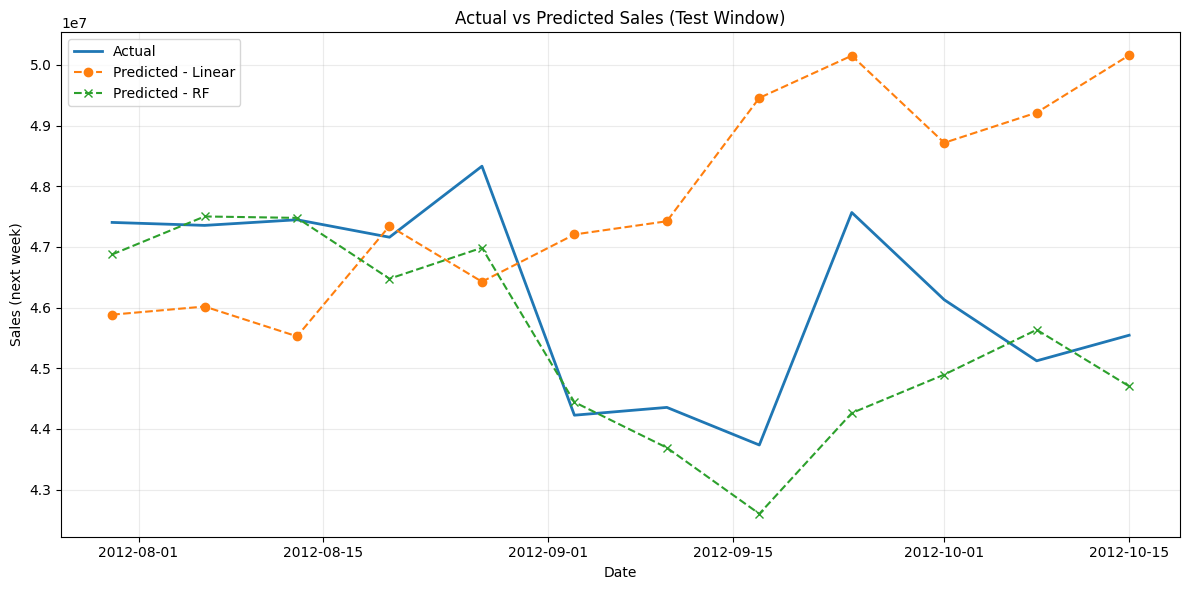

In [18]:
# Plot Actual vs Predicted Sales within a test window 

plt.figure(figsize=(12,6))
plt.plot(dates_test, y_test, label='Actual', linewidth=2)
plt.plot(dates_test, y_pred_lr, label='Predicted - Linear', linestyle='--', marker='o')
plt.plot(dates_test, y_pred_rf, label='Predicted - RF', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Sales (next week)')
plt.title('Actual vs Predicted Sales (Test Window)')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

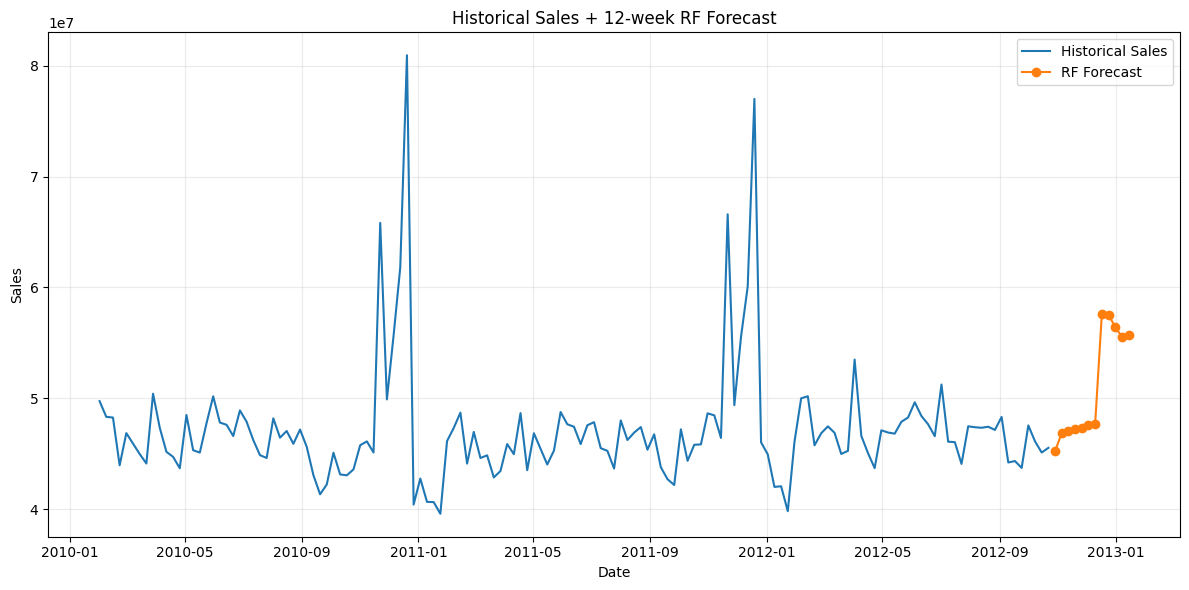

In [ ]:
# True Forecasting beyond test set (Optional), predict next 12 weeks

def forecast_horizon(ts_df, model, scaler=None, n_steps=12):
    # ts_df: DataFrame with Date & Sales historical series (weekly)
    base = ts_df.copy().sort_values('Date').reset_index(drop=True)
    preds = []
    # create seed features from base
    last_features = create_features(base).iloc[-1:].reset_index(drop=True)
    for i in range(n_steps):
        X_row = last_features[[c for c in last_features.columns if c not in ['Date','Sales','target']]].values
        if scaler is not None:
            X_row_scaled = scaler.transform(X_row)
            y_hat = model.predict(X_row_scaled)[0]
        else:
            y_hat = model.predict(X_row)[0]
        preds.append(y_hat)
        # append predicted value as next week observed for rolling/lags
        new_date = last_features.at[0,'Date'] + pd.Timedelta(weeks=1)
        base = pd.concat([base, pd.DataFrame({'Date':[new_date], 'Sales':[y_hat]})], ignore_index=True)
        last_features = create_features(base).iloc[-1:].reset_index(drop=True)
    return preds

# Retrain RF on full available features (exclude last row which lacks target)
X_full = features_df[X_cols].values
y_full = features_df['target'].values
rf_full = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf_full.fit(X_full, y_full)

future_steps = 12
future_preds = forecast_horizon(ts, rf_full, scaler=None, n_steps=future_steps)
future_dates = pd.date_range(start=ts['Date'].iloc[-1] + pd.Timedelta(weeks=1), periods=future_steps, freq='W-MON')

plt.figure(figsize=(12,6))
plt.plot(ts['Date'], ts['Sales'], label='Historical Sales')
plt.plot(future_dates, future_preds, label='RF Forecast', marker='o')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f'Historical Sales + {future_steps}-week RF Forecast')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()